In [1]:
# # Instalasi library Optuna
# !pip install optuna

In [2]:
# # Instalasi library PEFT
# !pip install peft

In [3]:
# # Instalasi library evaluate
# !pip install evaluate

In [ ]:
# Import library yang diperlukan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import resample
from datasets import Dataset, DatasetDict
from random import randrange

# Import library dari transformers dan optuna
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import optuna
from peft import LoraConfig, get_peft_model

# load metrics
import evaluate
import numpy as np
from transformers import DataCollatorWithPadding
from sklearn.metrics import f1_score

# Visualisasi Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


c:\Users\Acer-Nitro\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Muat dataset bahasa indonesia
ind_data_valid = pd.read_json("Data/ind-valid.json")
ind_data_test = pd.read_json("Data/indo-test.json")
ind_data_train = pd.read_json("Data/indo-train.json")

In [6]:
# Muat dataset bahasa jawa
jav_data_valid = pd.read_csv("Data/nusa_alinea-author-jav-valid.csv")
jav_data_train = pd.read_csv("Data/nusa_alinea-author-jav-train.csv")
jav_data_test = pd.read_csv("Data/nusa_alinea-author-jav-test.csv")

In [7]:
# Muat dataset bahasa sunda
sun_data_valid = pd.read_csv("Data/nusa_alinea-author-sun-valid.csv")
sun_data_train = pd.read_csv("Data/nusa_alinea-author-sun-train.csv")
sun_data_test = pd.read_csv("Data/nusa_alinea-author-sun-test.csv")

In [8]:
# Muat dataset bahasa Minang
min_data_valid = pd.read_csv("Data/nusa_alinea-author-min-valid.csv")
min_data_train = pd.read_csv("Data/nusa_alinea-author-min-train.csv")
min_data_test = pd.read_csv("Data/nusa_alinea-author-min-test.csv")

In [9]:
# Menampilkan beberapa baris pertama dari salah satu dataset (bahasa indonesia)
ind_data_valid.head()

,id,text,label
0,1504116000-trump-cek-lokasi-badai-harvey-di-te...,"Jakarta , CNN Indonesia - - Presiden Amerika S...","Jakarta , CNN Indonesia - - Presiden Amerika S..."
1,1484695838-panglima-tni-rapim-2017-punya-nilai...,"Jakarta , CNN Indonesia - - Panglima TNI Jende...","Jakarta , CNN Indonesia - - Panglima TNI Jende..."
2,1519334587-jelang-pilgub-jateng-ini-janji-sudi...,Suara.com - Calon Gubernur Jawa Tengah Sudirma...,Suara.com - Calon Gubernur Jawa Tengah Sudirma...
3,1497300420-jokowi-peringati-nuzulul-quran-bers...,"Jakarta , CNN Indonesia - - Presiden Joko Wido...","Jakarta , CNN Indonesia - - Presiden Joko Wido..."
4,1513474987-setya-novanto-diprediksi-tak-bakal-...,Kasus dugaan korupsi proyek e - KTP yang menje...,Kasus dugaan korupsi proyek e - KTP yang menje...


# Preprocessing data

## Menghapus kolom yang tidak diperlukan

In [10]:
# Menampilkan informasi dataframe bahasa indonesia valid
ind_data_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880 entries, 0 to 1879
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1880 non-null   object
 1   text    1880 non-null   object
 2   label   1880 non-null   object
dtypes: object(3)
memory usage: 44.2+ KB


In [11]:
# Mengahapus kolom yang tidak diperlukan (id dan label)
ind_data_valid = ind_data_valid.drop(columns=["id","label"])
ind_data_test = ind_data_test.drop(columns=["id","label"])
ind_data_train = ind_data_train.drop(columns=["id","label"])

In [12]:
# Menampilkan informasi dataframe bahasa jawa train
jav_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7298 entries, 0 to 7297
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         7298 non-null   int64 
 1   paragraph  7298 non-null   object
 2   author_id  7298 non-null   object
dtypes: int64(1), object(2)
memory usage: 171.2+ KB


In [13]:
# Mengahapus kolom yang tidak diperlukan (id dan author_id)
jav_data_valid = jav_data_valid.drop(columns=["id","author_id"])
jav_data_test = jav_data_test.drop(columns=["id","author_id"])
jav_data_train = jav_data_train.drop(columns=["id","author_id"])

In [14]:
# Menampilkan informasi dataframe bahasa sunda train
sun_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6688 entries, 0 to 6687
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         6688 non-null   int64 
 1   paragraph  6688 non-null   object
 2   author_id  6688 non-null   object
dtypes: int64(1), object(2)
memory usage: 156.9+ KB


In [15]:
# Mengahapus kolom yang tidak diperlukan (id dan author_id)
sun_data_valid = sun_data_valid.drop(columns=["id","author_id"])
sun_data_test = sun_data_test.drop(columns=["id","author_id"])
sun_data_train = sun_data_train.drop(columns=["id","author_id"])

In [16]:
# Menampilkan informasi dataframe bahasa minang test
min_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         2000 non-null   int64 
 1   paragraph  2000 non-null   object
 2   author_id  2000 non-null   object
dtypes: int64(1), object(2)
memory usage: 47.0+ KB


In [17]:
# Mengahapus kolom yang tidak diperlukan (id dan author_id)
min_data_valid = min_data_valid.drop(columns=["id","author_id"])
min_data_test = min_data_test.drop(columns=["id","author_id"])
min_data_train = min_data_train.drop(columns=["id","author_id"])

**Notd**: Tujuan menghapus kolom yaitu karena pada penelitian ini melakukan proses deteksi dialect oleh karena itu kolom yang diperlukan hanyalah kolom text, atau paragraph. Dimana nantinya hal tersebut berfungsi untuk melihat tata bahasa dan juga gaya penulisan antara bahasa satu dengan lainnya

## Menambahkan, Menggabungkan, dan merubah Kolom

In [18]:
# menambahkan kolom 'dialect'
ind_data_valid["dialect"] = "ind"
ind_data_test["dialect"] = "ind"
ind_data_train["dialect"] = "ind"

sun_data_test["dialect"] = "sun"
sun_data_train["dialect"] = "sun"
sun_data_valid["dialect"] = "sun"

jav_data_test["dialect"] = "jav"
jav_data_train["dialect"] = "jav"
jav_data_valid["dialect"] = "jav"

min_data_test["dialect"] = "min"
min_data_train["dialect"] = "min"
min_data_valid["dialect"] = "min"

In [19]:
# Menggabungkan dataset bahasa daerah (Sunda, Jawa, Minang)
daerah_data_valid = pd.concat([sun_data_valid, jav_data_valid], ignore_index=True)
daerah_data_valid = pd.concat([daerah_data_valid, min_data_valid], ignore_index=True)

daerah_data_test = pd.concat([sun_data_test, jav_data_test], ignore_index=True)
daerah_data_test = pd.concat([daerah_data_test, min_data_test], ignore_index=True)

daerah_data_train = pd.concat([sun_data_train, jav_data_train], ignore_index=True)
daerah_data_train = pd.concat([daerah_data_train, min_data_train], ignore_index=True)

In [20]:
# Mengubah nama kolom 'paragraph' menjadi 'text'
daerah_data_valid.rename(columns={'paragraph': 'text'}, inplace=True)
daerah_data_test.rename(columns={'paragraph': 'text'}, inplace=True)
daerah_data_train.rename(columns={'paragraph': 'text'}, inplace=True)

In [21]:
# Menggabungkan dataset bahasa Indonesia dengan dataset bahasa daerah
data_valid = pd.concat([ind_data_valid, daerah_data_valid], ignore_index=True)
data_test = pd.concat([ind_data_test, daerah_data_test], ignore_index=True)
data_train = pd.concat([ind_data_train, daerah_data_train], ignore_index=True)

In [22]:
# Menampilkan informasi data valid
data_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4270 entries, 0 to 4269
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     4270 non-null   object
 1   dialect  4270 non-null   object
dtypes: object(2)
memory usage: 66.8+ KB


In [23]:
# Menampilkan informasi data test
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8810 entries, 0 to 8809
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     8810 non-null   object
 1   dialect  8810 non-null   object
dtypes: object(2)
memory usage: 137.8+ KB


In [24]:
# Menampilkan informasi data train
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34040 entries, 0 to 34039
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     34040 non-null  object
 1   dialect  34040 non-null  object
dtypes: object(2)
memory usage: 532.0+ KB


In [25]:
# Mengubah teks di semua dataset menjadi huruf kecil (lowercase)
data_valid["text"] = data_valid["text"].str.lower()
data_test["text"] = data_test["text"].str.lower()
data_train["text"] = data_train["text"].str.lower()

## Mengurangi Jumlah dataset validation, testing, dan training

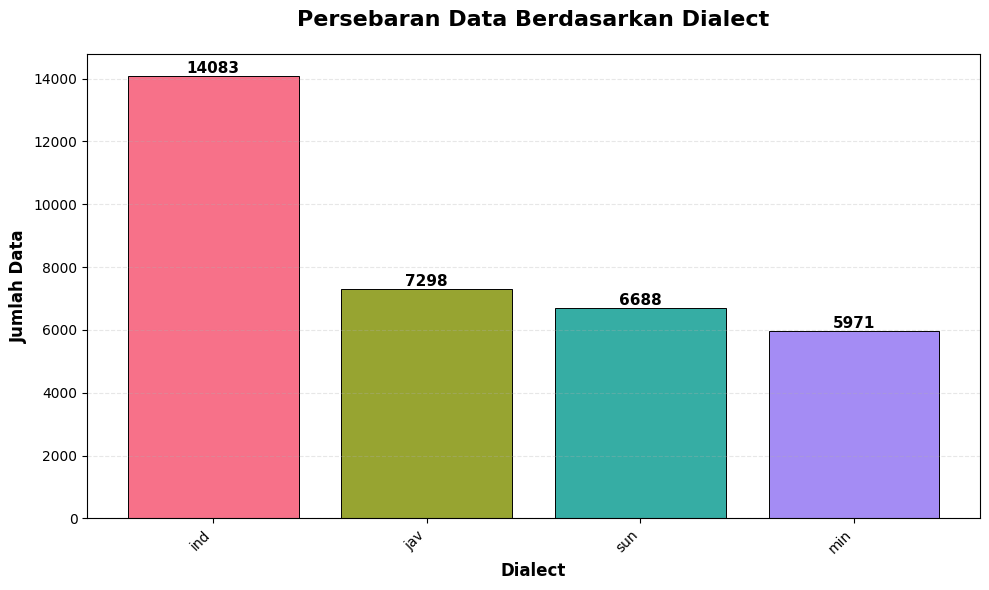

In [26]:
# Visualisasi persebaran data train berdasarkan dialect

 # Hitung distribusi dialect
dialect_counts = data_train['dialect'].value_counts()

# Buat bar chart
plt.figure(figsize=(10, 6))

# Buat bar chart dengan warna yang menarik
bars = plt.bar(dialect_counts.index, dialect_counts.values,
               color=sns.color_palette("husl", len(dialect_counts)),
               edgecolor='black', linewidth=0.7)

plt.title('Persebaran Data Berdasarkan Dialect', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Dialect', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Data', fontsize=12, fontweight='bold')

# Rotasi label x-axis jika diperlukan
plt.xticks(rotation=45, ha='right')

# Tambahkan grid untuk kemudahan membaca
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Tambahkan nilai di atas setiap bar
for bar, value in zip(bars, dialect_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(value), ha='center', va='bottom', fontweight='bold', fontsize=11)

# Sesuaikan layout agar tidak terpotong
plt.tight_layout()

# Tampilkan chart
plt.show()

### V1-Menghapus data training

In [27]:
# # Random sampling 10k dari seluruh dataset (Dikomentari sesuai instruksi sebelumnya)
# target_size = 10000
# data_random = data_train.sample(n=target_size, random_state=42).reset_index(drop=True)

In [28]:
# # Menghitung persebaran data sebelum dan sesudah random sampling (Dikomentari sesuai instruksi sebelumnya)
# original_counts = data_train['dialect'].value_counts()
# random_counts = data_random['dialect'].value_counts()

In [29]:
# # Visualisasi persebaran data sebelum dan sesudah random sampling (Dikomentari sesuai instruksi sebelumnya)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# # Before
# original_counts.plot(kind='bar', ax=ax1, color='lightcoral')
# ax1.set_title('Data Asli')
# ax1.set_ylabel('Jumlah Data')
# ax1.tick_params(axis='x', rotation=45)

# # After
# random_counts.plot(kind='bar', ax=ax2, color='gold')
# ax2.set_title(f'Random Sampling ({len(data_random)})')
# ax2.set_ylabel('Jumlah Data')
# ax2.tick_params(axis='x', rotation=45)

# plt.tight_layout()
# plt.show()

### V2-Mengapus data training (balance)

In [30]:
# Target data seimbang per dialek
# target_per_dialect = 2500
target_per_dialect = 375

# Melakukan balanced sampling untuk data training
balanced_data = []
for dialect in data_train['dialect'].unique():
    dialect_data = data_train[data_train['dialect'] == dialect]
    sampled = resample(dialect_data, n_samples=target_per_dialect,
                      random_state=42, replace=False)
    balanced_data.append(sampled)

# Menggabungkan dan mengacak data training yang sudah seimbang
data_training = pd.concat(balanced_data, ignore_index=True)
data_training = data_training.sample(frac=1, random_state=42).reset_index(drop=True)

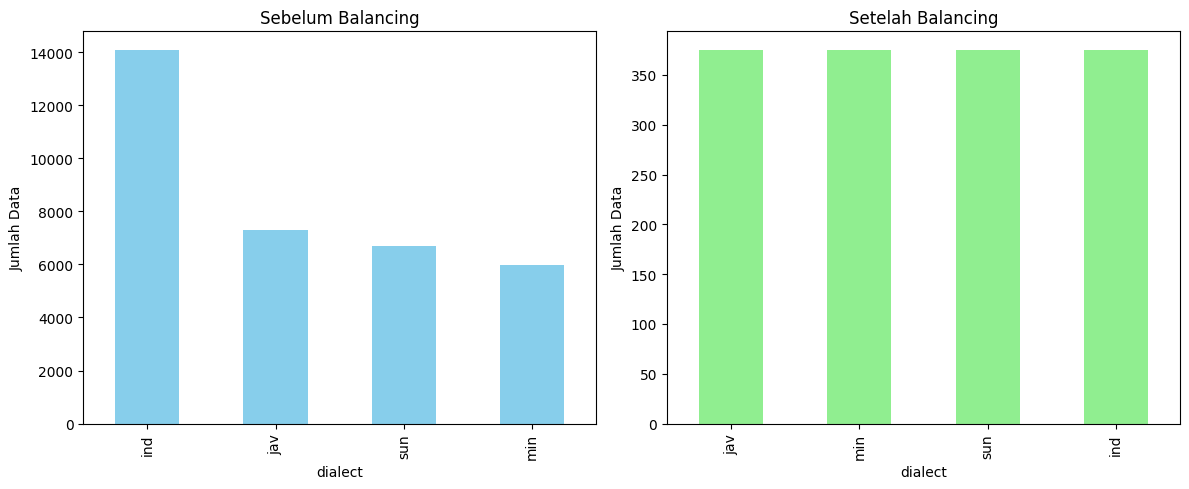

In [31]:
# Visualisasi persebaran data training sebelum dan setelah balancing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Sebelum Balancing
data_train['dialect'].value_counts().plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Sebelum Balancing')
ax1.set_ylabel('Jumlah Data')

# Setelah Balancing
data_training['dialect'].value_counts().plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Setelah Balancing')
ax2.set_ylabel('Jumlah Data')

plt.tight_layout()
plt.show()

### menghapus data testing menjadi 550

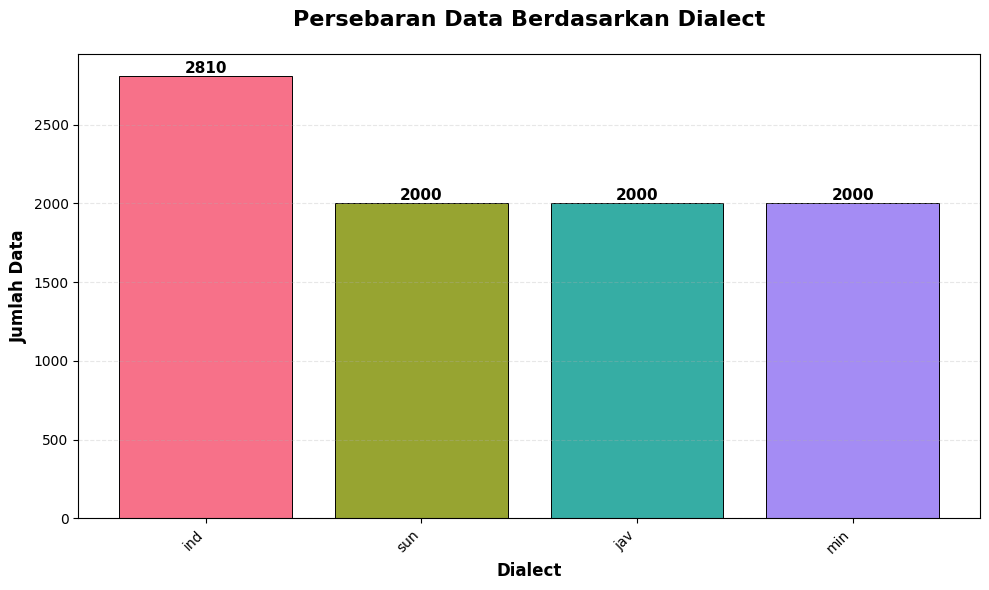

In [32]:
# Visualisasi persebaran data testing
 # Hitung distribusi dialect
dialect_counts = data_test['dialect'].value_counts()

# Buat bar chart
plt.figure(figsize=(10, 6))

# Buat bar chart dengan warna yang menarik
bars = plt.bar(dialect_counts.index, dialect_counts.values,
               color=sns.color_palette("husl", len(dialect_counts)),
               edgecolor='black', linewidth=0.7)

plt.title('Persebaran Data Berdasarkan Dialect', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Dialect', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Data', fontsize=12, fontweight='bold')

# Rotasi label x-axis jika diperlukan
plt.xticks(rotation=45, ha='right')

# Tambahkan grid untuk kemudahan membaca
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Tambahkan nilai di atas setiap bar
for bar, value in zip(bars, dialect_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(value), ha='center', va='bottom', fontweight='bold', fontsize=11)

# Sesuaikan layout agar tidak terpotong
plt.tight_layout()

# Tampilkan chart
plt.show()

In [33]:
# Random sampling  dari seluruh dataset testing
target_size_test = 500
data_testing = data_test.sample(n=target_size_test, random_state=42).reset_index(drop=True)

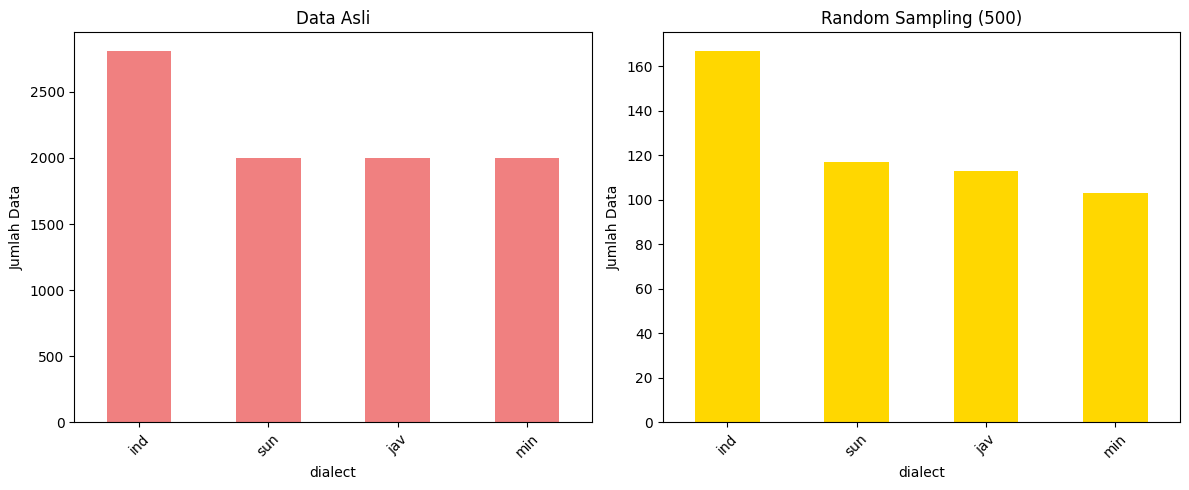

In [34]:
# Menghitung dan memvisualisasikan persebaran data testing sebelum dan sesudah random sampling
original_counts_test = data_test['dialect'].value_counts()
random_counts_test = data_testing['dialect'].value_counts()

# Visualisasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Sebelum
original_counts_test.plot(kind='bar', ax=ax1, color='lightcoral')
ax1.set_title('Data Asli')
ax1.set_ylabel('Jumlah Data')
ax1.tick_params(axis='x', rotation=45)

# Sesudah
random_counts_test.plot(kind='bar', ax=ax2, color='gold')
ax2.set_title(f'Random Sampling ({len(data_testing)})')
ax2.set_ylabel('Jumlah Data')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Hapus Data validation

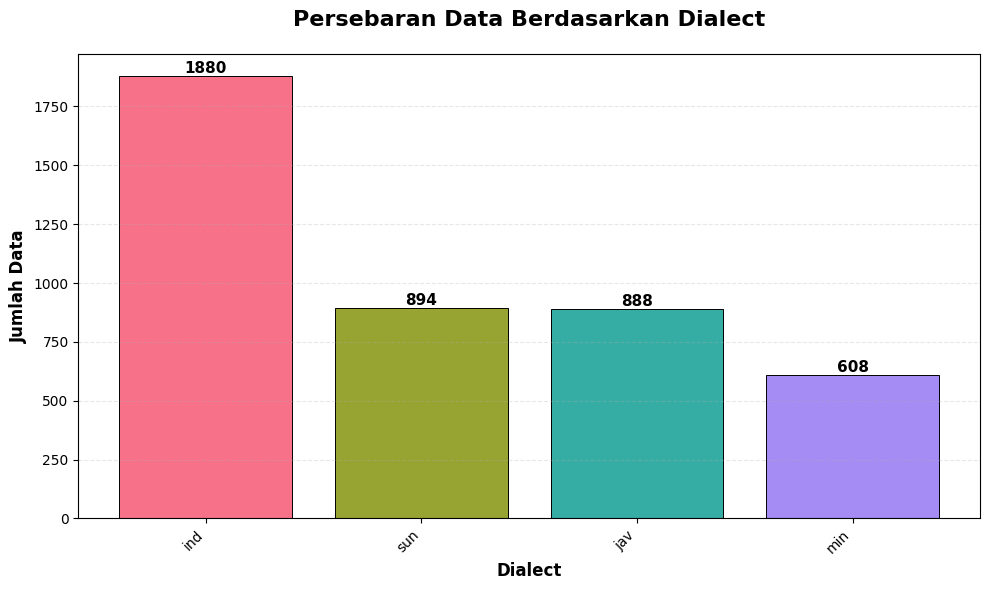

In [35]:
# Visualisasi persebaran data validation
 # Hitung distribusi dialect
dialect_counts = data_valid['dialect'].value_counts()

# Buat bar chart
plt.figure(figsize=(10, 6))

# Buat bar chart dengan warna yang menarik
bars = plt.bar(dialect_counts.index, dialect_counts.values,
               color=sns.color_palette("husl", len(dialect_counts)),
               edgecolor='black', linewidth=0.7)

plt.title('Persebaran Data Berdasarkan Dialect', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Dialect', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Data', fontsize=12, fontweight='bold')

# Rotasi label x-axis jika diperlukan
plt.xticks(rotation=45, ha='right')

# Tambahkan grid untuk kemudahan membaca
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Tambahkan nilai di atas setiap bar
for bar, value in zip(bars, dialect_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(value), ha='center', va='bottom', fontweight='bold', fontsize=11)

# Sesuaikan layout agar tidak terpotong
plt.tight_layout()

# Tampilkan chart
plt.show()

In [36]:
# Random sampling  dari seluruh dataset validation
target_size_test = 500
data_validation = data_test.sample(n=target_size_test, random_state=42).reset_index(drop=True)

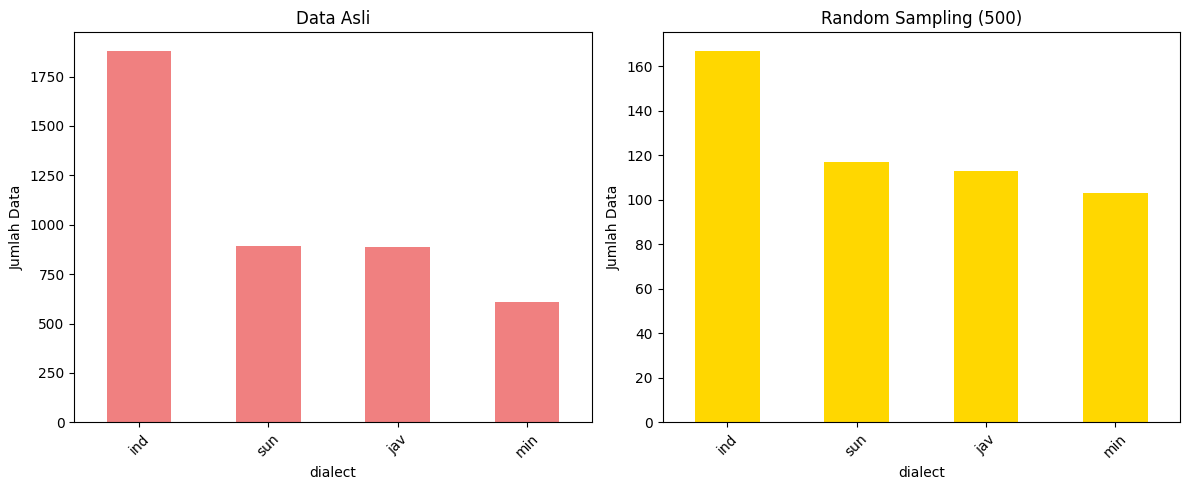

In [37]:
# Menghitung dan memvisualisasikan persebaran data testing sebelum dan sesudah random sampling
original_counts_test = data_valid['dialect'].value_counts()
random_counts_test = data_validation['dialect'].value_counts()

# Visualisasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Sebelum
original_counts_test.plot(kind='bar', ax=ax1, color='lightcoral')
ax1.set_title('Data Asli')
ax1.set_ylabel('Jumlah Data')
ax1.tick_params(axis='x', rotation=45)

# Sesudah
random_counts_test.plot(kind='bar', ax=ax2, color='gold')
ax2.set_title(f'Random Sampling ({len(data_testing)})')
ax2.set_ylabel('Jumlah Data')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Penjelasan

**Noted:**

Pada tahap ini terdapat beberapa langkah yang dilakukan, mulai dari merubah nama kolom pada dataset, dan juga melakukan proses penggabungan dataset. Hal ini bertujuan agar data nantinya dapat digunakan dalam pelatihan model. Selain itu juga terdapat proses penghapusan atau penyeimbangan dataset, sebenarnya hal ini opsional untuk dilakukan. Pada tahap penghapusan dilakukan proses imbalance data dimana tiap kategori terdiri dari 375 data, jadi secara keseluruhan total data training yaitu 1500. Alasan menggunakan 1500 data yaitu karena pada proses pemodelan akan menjadi lebih ringan tentunya hal tersebut juga berdampak pada peforma model yang dihasilkan. untuk data testing berjumlah 500 data, dan data validation berjumlah 500.

In [38]:
# Asumsi Anda sudah punya kamus pemetaan seperti ini:
label2id = {'ind': 0, 'jav': 1, 'sun': 2, 'min': 3}

# menambahkan kolom label berdasarkan pemetaan dialect
data_training['label'] = data_training['dialect'].map(label2id)
data_validation['label'] = data_validation['dialect'].map(label2id)
data_testing['label'] = data_testing['dialect'].map(label2id)

In [39]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

### Mengubah dataframe kedalam bentuk dataset

In [40]:
# Menampilkan 5 baris data teratas dari data training
data_training.head()

,text,dialect,label
0,omah sing ana ning pojok dalan kuwi jarena oma...,jav,1
1,tren nan muncul satelah korona manyarang salur...,min,3
2,abdi kacida reuwasna basa nuju meser es krim d...,sun,2
3,pernah basa sma abdi ngiringan lomba ngadongen...,sun,2
4,pagawean arka sapopoe ngan nyonyoo wae hp. ti ...,sun,2


In [41]:
# Mengubah objek dataframe menjadi objek dataset dari library datasets
training = Dataset.from_pandas(data_training)
validation = Dataset.from_pandas(data_validation)
testing = Dataset.from_pandas(data_testing)

In [42]:
# Menggabungkan ketiga dataset menjadi satu DatasetDict
dialect_detect = DatasetDict({
    'train': training,
    'validation': validation,
    'test': testing
})

In [43]:
# Menampilkan struktur DatasetDict
print("Struktur Dataset:", dialect_detect)

Struktur Dataset: DatasetDict({
    train: Dataset({
        features: ['text', 'dialect', 'label'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['text', 'dialect', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text', 'dialect', 'label'],
        num_rows: 500
    })
})


# Tokenisasi

In [44]:
# Menampilkan sampel acak dari data training
random_id = randrange(len(dialect_detect['train']))
dialect_detect['train'][random_id]

{'text': 'sanjato tradisional yang mampunyoi banyak makna salah satunyo barasa dari daerah aceh yang banamo rencong/rincoeng/rinjoeng. sanjato rencong ko alah ado pado maso kesultanan islam sakitari abad ke-13. masyarakat aceh manggunoan rencong sebagai sanjato untuak malawan penjajah portugis dan belanda. manuruik masyarakat aceh sanjato ko marupokan simbol keberanaian, keperkasaan, pertahanan diri, jo perjuangan masyarakat aceh dari maso ka maso. jadi, sanjato tradisional banamo rencong dari aceh ko bagitu banyak makna yang samo makasuik nyo. rencong kalau dipacik pas bana gagang untuak awak mamacik nyo dan ujuang rencong ko agak malangkuang yang bagian ujuang nyo se. sanjato yang bernilai bana bagi kemajuan masyarakat aceh pado maso penjajahan.',
 'dialect': 'min',
 'label': 3}

Model yang digunakan dalam project ini yaitu NusaBert-base. model ini merupakan model yang dibuat oleh LazarusNLP, dimana model ini dilatih dengan menggunakan bahasa indonesia, bahasa inggris dan juga bahasa daerah yang ada di Indonesia seperti bahasa jawa, sunda, indonesia, dan minang. Oleh karena itu saya memilih menggunakan model ini untuk digunakan dalam pembuatan project deteksi dialect, hanya terdapat kekurangan dalam memilih model ini yaitu model ini belum mendukung bahasa minang.

In [45]:
# Menentukan model pre-trained yang akan digunakan
# model_name = "Sahabat-AI/Llama-Sahabat-AI-v2-70B-IT"
model_name = "LazarusNLP/NusaBERT-base"

# Memuat tokenizer dari model pre-trained
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [46]:
# Fungsi untuk menghitung panjang token setiap teks
def get_token_length(example):
    return {"token_length": len(tokenizer.encode(example['text']))}

In [47]:
# Menerapkan fungsi get_token_length pada data training untuk mendapatkan panjang token semua kalimat
dataset_with_lengths = dialect_detect['train'].map(get_token_length)

Map: 100%|██████████| 1500/1500 [00:01<00:00, 941.18 examples/s]


In [48]:
# Analisis distribusi panjang token
token_lengths = dataset_with_lengths['token_length']

print(f"Panjang token Min: {np.min(token_lengths)}")
print(f"Panjang token Max: {np.max(token_lengths)}")
print(f"Panjang token Rata-rata: {np.mean(token_lengths):.2f}")
print("-" * 30)

Panjang token Min: 100
Panjang token Max: 1264
Panjang token Rata-rata: 251.71
------------------------------


In [49]:
# Hitung persentil untuk mendapatkan rekomendasi nilai max_length
p95 = np.percentile(token_lengths, 95)
p98 = np.percentile(token_lengths, 98)
p99 = np.percentile(token_lengths, 99)

print(f"Rekomendasi max_length (Persentil ke-95): {int(p95)}")
print(f"Rekomendasi max_length (Persentil ke-98): {int(p98)}")
print(f"Rekomendasi max_length (Persentil ke-99): {int(p99)}")

Rekomendasi max_length (Persentil ke-95): 577
Rekomendasi max_length (Persentil ke-98): 720
Rekomendasi max_length (Persentil ke-99): 834


**Noted:**

Pada tahap ini sebelum masuk kedalam proses tokenizer, maka langkah yang dilakukan disini yaitu menentukan nilai max lenght yang optimal. Seperti yang terlihat bahwa persentil dibuadari 95-99, alasan memilih persentil tersebut agar dapat meminimalisir hilangnya informasi yang ada. Oleh karena itu dengan memilih persentil 95-99 artinya kita hanya memotong 2% hingga 5% data terpanjang, karena max length sendiri memiliki batas maksimal 512. Tetapi jika memilih persentil 100 maka memiliki kemungkinan bahwa ruang yang digunakan terlalu berlebihan.

Kesimpulannya, berdasarkan dari hasil persentil yang didapatkan yaitu pada persentil 95 dengan total 783. maka dari hal tersebut kita dapat menarik kesimpulan bahwa nilai max lenght yang digunakan adalah 512.

In [50]:
# Mengatur nilai max_length untuk tokenizer
tokenizer.model_max_length = 512

In [51]:
# Fungsi helper untuk tokenisasi batch data
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, return_tensors="pt")

# Mengatur pad_token jika belum terdapat pad_token (menggunakan eos_token jika pad_token kosong)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Tokenisasi dataset
# Mengubah nama kolom 'label' menjadi 'labels' agar sesuai dengan standar library transformers
raw_dataset =  dialect_detect.rename_column("label", "labels")
tokenized_dataset = raw_dataset.map(tokenize, batched=True,remove_columns=["text"])

Map: 100%|██████████| 500/500 [00:00<00:00, 2326.75 examples/s]


In [52]:
# Menampilkan kunci fitur dari dataset training yang sudah ditokenisasi
print(tokenized_dataset["train"].features.keys())

dict_keys(['dialect', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'])


In [53]:
# Menampilkan struktur DatasetDict yang sudah ditokenisasi
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['dialect', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['dialect', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
    test: Dataset({
        features: ['dialect', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [54]:
# Menampilkan 5 sampel acak dari data train yang sudah ditokenisasi
sampel_acak = tokenized_dataset['train'].shuffle(seed=42).select(range(5))

# Mengubah ke dalam bentuk data frame untuk tampilan
df_sampel = pd.DataFrame(sampel_acak)
print("5 Sampel Acak dari Data Train")
print(df_sampel)

5 Sampel Acak dari Data Train
  dialect  labels                                          input_ids  \
0     sun       2  [2, 11258, 19644, 30953, 14, 31577, 30468, 257...   
1     min       3  [2, 1248, 25765, 31292, 282, 5713, 34, 25765, ...   
2     ind       0  [2, 678, 30468, 18929, 30355, 300, 30469, 3046...   
3     ind       0  [2, 678, 30468, 18929, 30355, 300, 30469, 3046...   
4     jav       1  [2, 349, 28532, 7620, 280, 31260, 4739, 10510,...   

                                      token_type_ids  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

**Note:**

Pada tahap ini melakukan proses tokenisasi dimana membuat format dataset yang dimiliki agar sepenuhnya siap dilatih oleh model LLM. Berikut penjelasan secara detail:


- Tokenize: Merupakan langkah utama dalam tahap ini, berfungsi untuk mengubah setiap kalimat dalam kolom text menjadi token (angka). seperti yang terlihat hasilnya pada proses sebelumnya. padding dengan menggunakan "max_length" dan Truncation=True bertujuan untuk memastikan semua kalimat panjang agar menjadi seragam.
- if tokenizer.pad_token is None: Dari referensi yang diambil code, atau tahap ini bertujuan untuk berjaga jaga alasannya yaitu beberapa model secara alami tidak memiliki token khusus padding. baris ini bertujuan jika hal tersebut tidak terdapat dalam model program tidak akan mengalami error.
- raw_dataset =  dialect_detect.rename_column("label", "labels"): memiliki fungsi yaitu mengubah nama kolom awalnya label menjadi labels, hal ini bertujuan untuk memenuhi syarat dari library transformer.
- tokenized_dataset = raw_dataset.map(tokenize, batched=True,remove_columns=["text"]): tahap akhir dari proses tokenisasi dimana menghapus kolom text asli, setelah mengubah semua kata yang ada pada dataset tersebut kedalam bentuk token. Alasan kolom dihapus adalah karena tidak diperlukan lagi oleh model nantinya

# Penentuan dan Eksplorasi Hyperparameter dengan Optuna

In [55]:
# Menyiapkan label model - berguna untuk inferensi
# Mengambil nama-nama label dari kunci dictionary label2id yang sudah ada
labels = list(label2id.keys())
num_labels = len(labels)

# Membuat ulang di sini untuk memastikan konsistensi, tetapi bisa juga menggunakan yang sudah ada.
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}


print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'ind': 0, 'jav': 1, 'sun': 2, 'min': 3}
id2label: {0: 'ind', 1: 'jav', 2: 'sun', 3: 'min'}


In [56]:
# # Mencari nilai hyperparameter optimal dengan optuna
# def objective(trial):
#     model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4, id2label=id2label, label2id=label2id)

#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
#     batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

#     training_args = TrainingArguments(
#         output_dir='./results',
#         learning_rate=learning_rate,
#         per_device_train_batch_size=batch_size,
#         num_train_epochs=1,
#         eval_strategy="epoch",
#         logging_steps=500,
#     )

#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         # Gunakan dataset yang sudah diperkecil
#         train_dataset= tokenized_dataset["train"],
#         eval_dataset= tokenized_dataset["validation"]
#     )

#     trainer.train()
#     eval_result = trainer.evaluate()

#     return eval_result['eval_loss']

# # Pastikan arahnya 'minimize' karena kita mengoptimalkan loss
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=5)

# print("Best hyperparameters:", study.best_params)

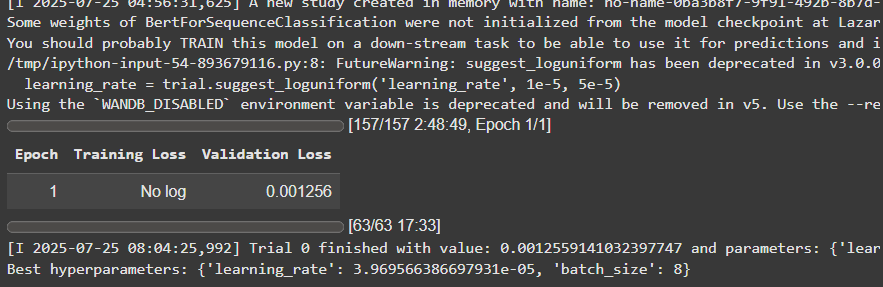

# Proses Fine Tuning

In [57]:
# Menampilkan fitur dari raw_dataset training (sebelum tokenisasi)
print(raw_dataset["train"].features)

{'text': Value('string'), 'dialect': Value('string'), 'labels': Value('int64')}


In [58]:
  # Memuat model pre-trained untuk klasifikasi sekuen
  # Menggunakan identifier model yang sama dengan tokenizer

  model = AutoModelForSequenceClassification.from_pretrained(
      model_name, # Menggunakan variabel model_name
      num_labels=num_labels,
      id2label=id2label,
      label2id=label2id
  )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at LazarusNLP/NusaBERT-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## PEFT Lora

In [59]:
# Konfigurasi LoRA
lora_config = LoraConfig(
    task_type = 'SEQ_CLS',
    r = 4,
    lora_alpha = 32,
    lora_dropout = 0.01,
    target_modules = ['query', 'key', 'value'] # Corrected target modules
)

# Menerapkan LoRA pada model
peft_model = get_peft_model(model, lora_config)

**Noted:**

setelah melakukan proses tokenisasi maka langkah selanjutnya yang dilakukan adalah tahap fine tuning. pada tahap ini menggunakan PEFT alasannya karena lebih cepat dan lebih ringan, tentunya hasil yang didapatkan berkemungkinan tidak akan sebaik jika melakukan proses full fine-tuning. Pada PEFT terdapat parameter yang harus ditentukan dan ditetapkan, parameter yang digunakan tersebut tidak ditetapkan sendiri, akan tetapi diambil dari referensi yang menggunakan PEFT lora.

# Model dan Evaluasi

In [60]:

# Inisialisasi data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:

 
# Metric helper method
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    score = f1_score(
            labels, predictions, labels=labels, pos_label=1, average="weighted"
        )
    return {"f1": float(score) if score == 1 else score}

In [62]:
# # Fungsi untuk menghitung metrik evaluasi (Accuracy dan ROC AUC)
# accuracy = evaluate.load("accuracy")
# auc_score = evaluate.load("roc_auc")

# def compute_metrics(eval_pred):
#     # get predictions
#     predictions, labels = eval_pred

#     # apply softmax to get probabilities
#     probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)

#     # compute auc for multi-class
#     # Use 'ovr' strategy for multi-class ROC AUC
#     auc = np.round(auc_score.compute(prediction_scores=probabilities,
#                                      references=labels, multi_class='ovr')['roc_auc'],3)

#     # predict most probable class
#     predicted_classes = np.argmax(predictions, axis=1)
#     # compute accuracy
#     acc = np.round(accuracy.compute(predictions=predicted_classes,
#                                      references=labels)['accuracy'],3)

#     return {"Accuracy": acc, "AUC": auc}

dalam langkah berikut untuk penentuan hyperparameter saya melakukan beberapa langkah. berikut penjelasannya:
- hyperparameter pertama saya menggunakan dari proses optuna yang telah dilakukan.
  - lr = 3.969e-05
  - batch_size = 8
  - num_epochs = 1
- untuk uji coba kedua saya menggunakan referensi project yang telah dilakukan link: https://medium.com/@dooterior/fine-tuning-an-llm-for-sentiment-analysis-08b951af289e
  - lr = 1e-3
  - batch_size = 4
  - num_epochs = 5

dari 3 jenis hyperparameter yang ada, nantinya akan dilihat mana yang dapat memberikan hasil yang baik, dan paling optimal.

### Ujicoba 1

In [63]:
# hyperparameters uji coba 1
lr_1 = 1e-3
batch_size_1 = 8
num_epochs_1 = 1

In [64]:
# Menginisialisasi Trainer dan memulai pelatihan model - uji coba 1
training_args_1 = TrainingArguments(
    output_dir= model_name,
    learning_rate=lr_1,
    per_device_train_batch_size=batch_size_1,
    per_device_eval_batch_size=batch_size_1,
    num_train_epochs=num_epochs_1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [65]:
trainer_1 = Trainer(
    model=model,
    args=training_args_1,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_1.train()

C:\Users\Acer-Nitro\AppData\Local\Temp\ipykernel_63560\283430423.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_1 = Trainer(
c:\Users\Acer-Nitro\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,F1
1,No log,0.000252,1.000000


TrainOutput(global_step=188, training_loss=0.054008950578405504, metrics={'train_runtime': 3528.5717, 'train_samples_per_second': 0.425, 'train_steps_per_second': 0.053, 'total_flos': 395707060224000.0, 'train_loss': 0.054008950578405504, 'epoch': 1.0})

c:\Users\Acer-Nitro\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


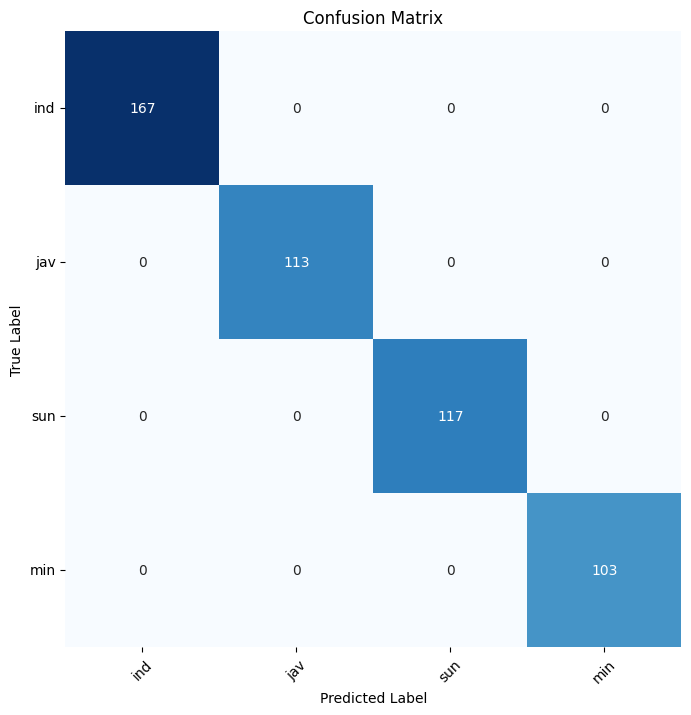

In [66]:
# Menghitung prediksi pada data validasi
predictions = trainer_1.predict(tokenized_dataset["validation"])
# Menghitung confusion matrix
cm = confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=1))
# Membuat DataFrame untuk confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
# Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
